## Initialization

In [1]:
'''
This is the source code for bayesian LSTM for electricity load prediction.
@copyright: Copyright 2020 Mr. Kevin Hu. (https://github.com/KevinHooah)
@licence: Apache License 2.0 (http://www.apache.org/licenses/)
@author: Kevin Hu
'''

'\nThis is the source code for bayesian LSTM for electricity load prediction.\n@copyright: Copyright 2020 Mr. Kevin Hu. (https://github.com/KevinHooah)\n@licence: Apache License 2.0 (http://www.apache.org/licenses/)\n@author: Kevin Hu\n'

In [2]:
'''
utf——8
Kevin——Coded
'''
!nvidia-smi

Wed May 27 22:29:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 436.50       Driver Version: 436.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:01:00.0  On |                  N/A |
| 47%   29C    P8    11W / 250W |    512MiB /  8192MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Preparation

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)
import numpy as np
import matplotlib.pyplot as plt
SMALL_SIZE = 25
MEDIUM_SIZE = 28
BIGGER_SIZE = 44
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIGGER_SIZE)  
%matplotlib inline
import seaborn as sns
import math
from math import sqrt
from tqdm import tqdm
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(tensorflow.__version__)

1.14.0


In [4]:
df = pd.read_csv('sunspots.csv')
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.head(10)

,Sunspot
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
1749-06-30,139.2
1749-07-31,158.0
1749-08-31,110.5
1749-09-30,126.5


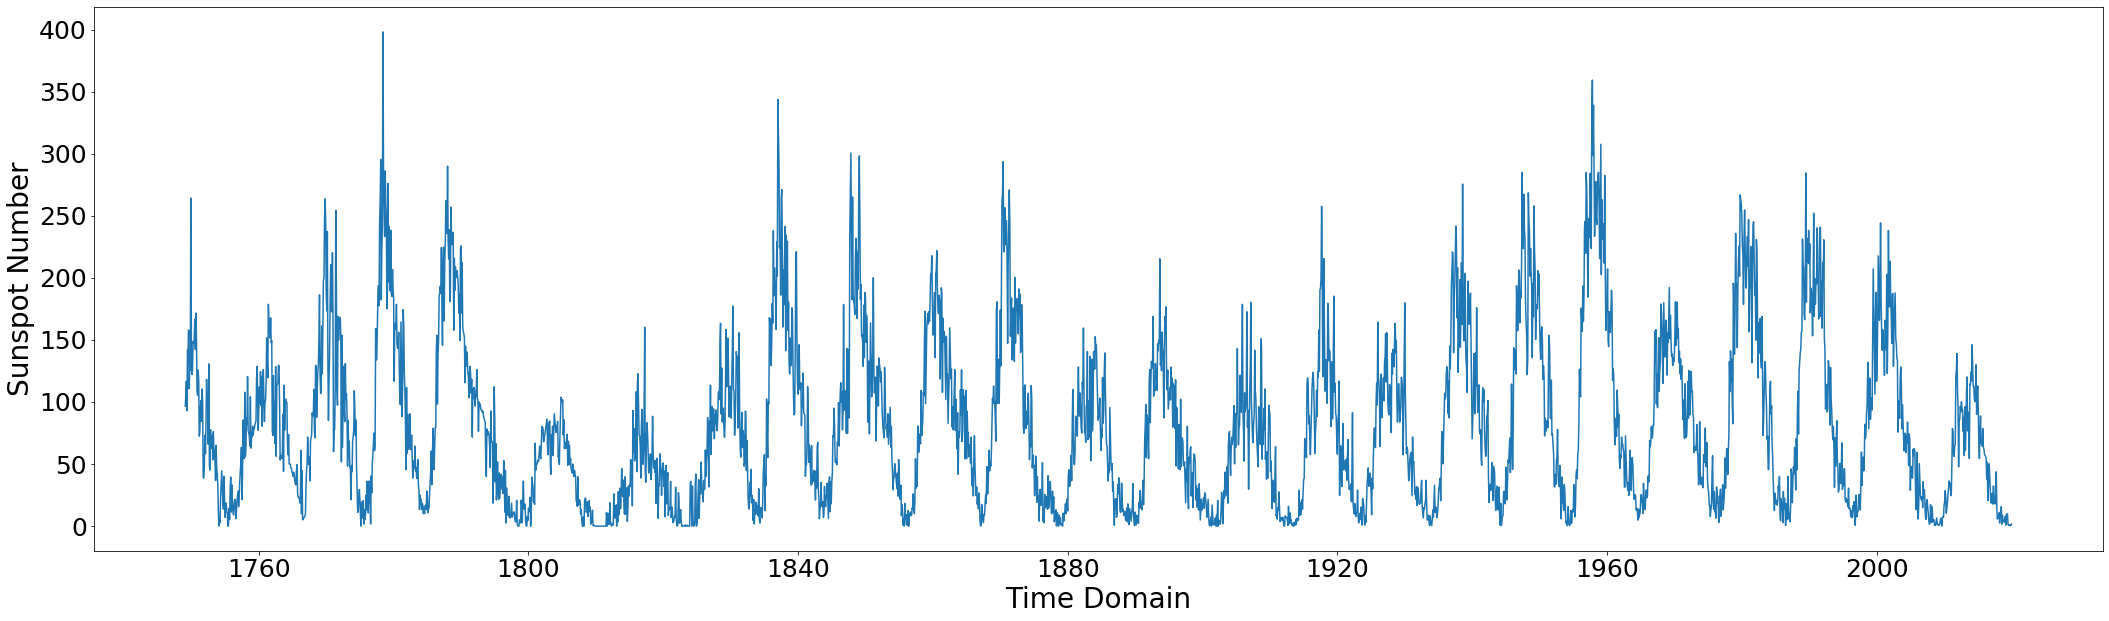

In [5]:
plt.figure(figsize=(36,10))
plt.plot(df.Sunspot)
plt.xlabel('Time Domain')
plt.ylabel('Sunspot Number')
plt.show()

In [6]:
np.random.seed(42)

In [7]:
dataset = df.Sunspot.values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)

In [8]:
# LSTM is sensitive to scale, thus a scaler is necessary.
scaler = RobustScaler()
dataset = scaler.fit_transform(dataset)

In [9]:
#Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2178 1074


In [10]:
def creat_dataset(data, lagTerm=1):
    # To create the dataset for later use.
    # lagTerm: How many previous timestemp's data will be used.
    dataX, dataY = [],[]
    for i in range(len(data) - lagTerm -1):
        cache = data[i:(i+lagTerm),0]
        dataX.append(cache)
        dataY.append(data[i+lagTerm,0])
    return np.array(dataX), np.array(dataY)


In [11]:
look_back = 6
trainX,trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)

In [12]:
#reshape input into to be [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# Set a valida set to avoid overfitting
validX = trainX[2101:]
validY = trainY[2101:]
trainX = trainX[:2100]
trainY = trainY[:2100]

# Model

In [14]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(256, input_shape=(1,look_back),dropout=0.1, recurrent_dropout = 0.1)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    def heteroscedastic_loss(true,pred):
        # Customized loss function for aleatoric uncertainty
        mean_ = pred[:,0]
        logVar = pred[:,1]
        precision = tensorflow.keras.backend.exp(-logVar)
        return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss=heteroscedastic_loss)
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss


In [15]:
# Early stop callback function.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

In [16]:
theModel, ELBO = fitModel(300,1,trainX,trainY,validX,validY,[early_stopping_cb])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 2100 samples, validate on 70 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
2100/2100 - 2s - loss: -6.0882e-02 - val_loss: -3.4444e-01
Epoch 2/300
2100/2100 - 0s - loss: -5.4660e-01 - val_loss: -7.3051e-01
Epoch 3/300
2100/2100 - 0s - loss: -7.4919e-01 - val_loss: -8.1061e-01
Epoch 4/300
2100/2100 - 0s - loss: -7.5346e-01 - val_loss: -8.1404e-01
Epoch 5/300
2100/2100 - 0s - loss: -7.7004e-01 - val_loss: -8.5886e-01
Epoch 6/300
2100/2100 - 0s - loss: -7.9980e-01 - val_loss: -8.3770e-01
Epoch 7/300
2100/2100 - 0s - loss: -7.8994e-01 - val_loss: -8.5593e-01
Epoch 8/300
2100/2100 - 0s - loss: -7.8287e-01 - val_loss: -8.2214e-01
Epoch 9/300
2100/2100 - 0s - loss: -7.7766e-01 - val_loss: -8.2682e-01
Epoch 10/300
2100/2100 - 0s - loss: -7.8825e-01 - val_loss: -8.3181e-01
Epoch 11/300
2100/2100 - 0s - l

In [17]:
eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.73it/s]


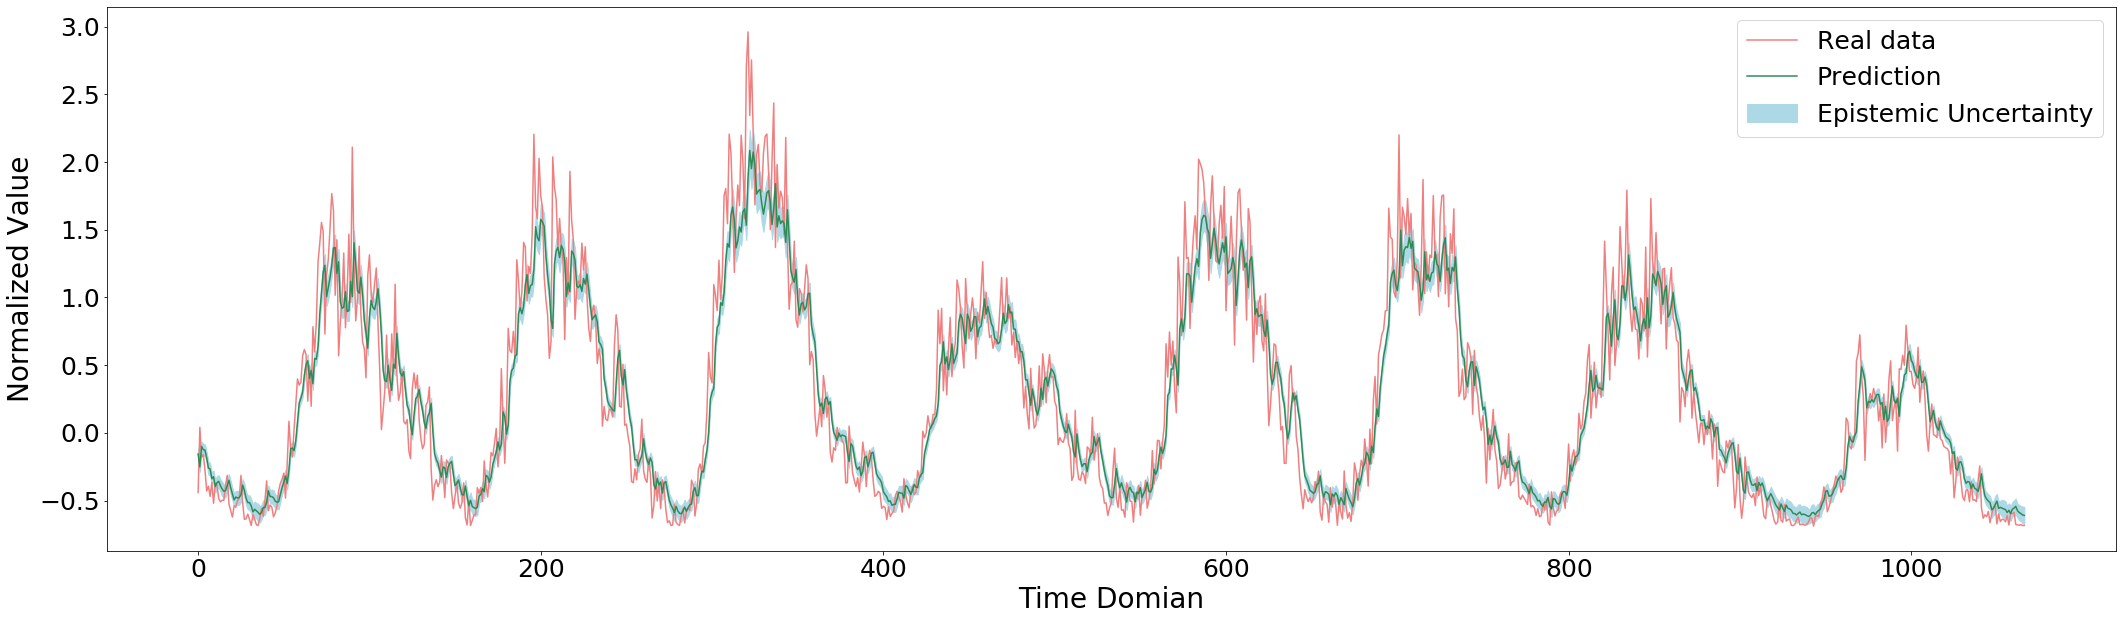

In [18]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*v**0.5, m + 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

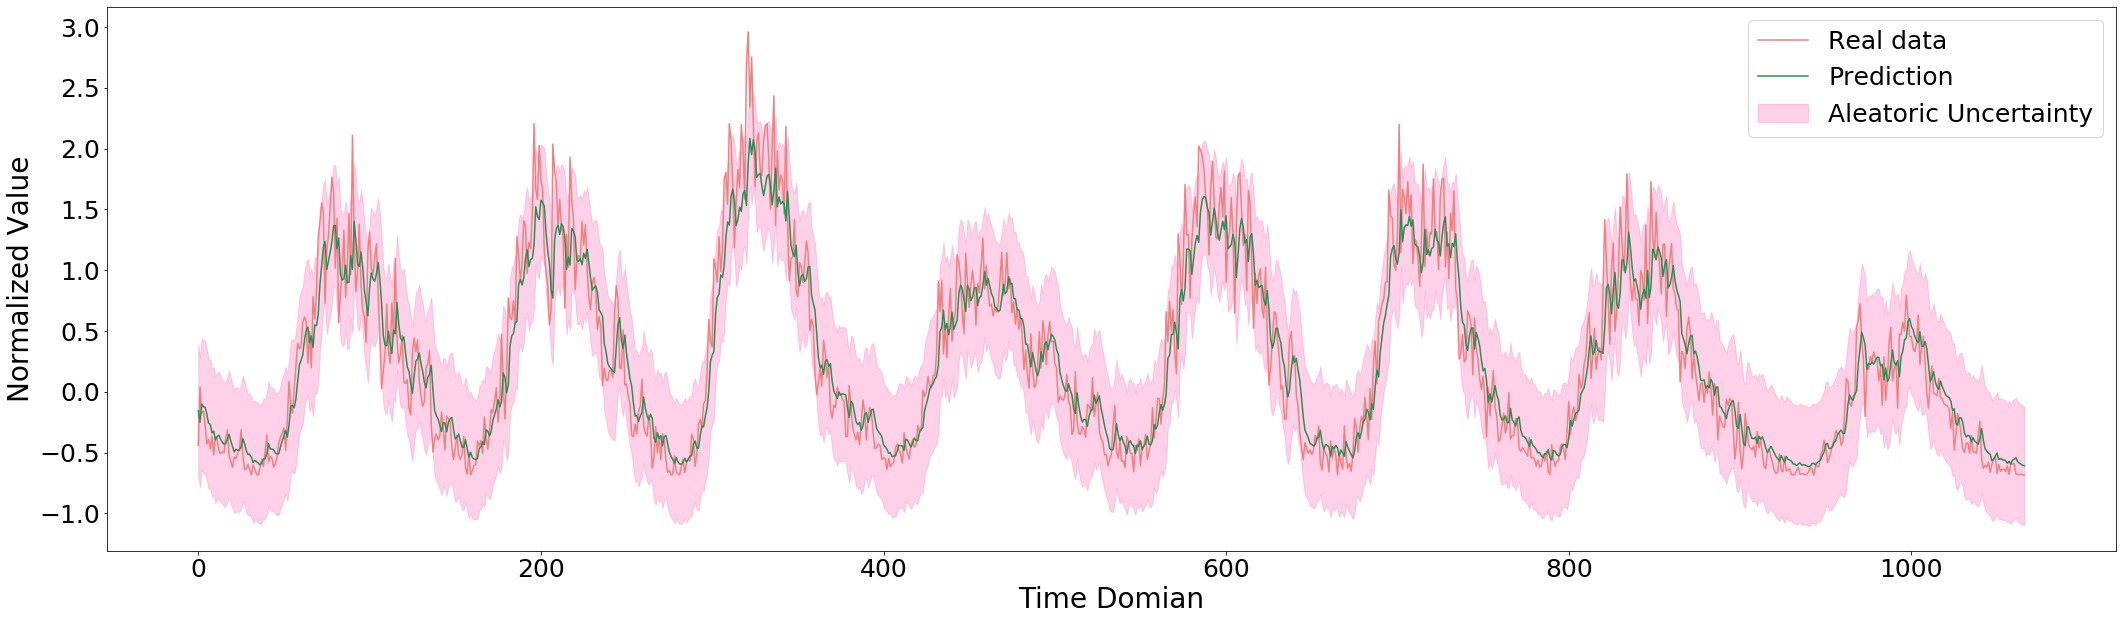

In [21]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*a_u**0.5, m + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

In [22]:
# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Test RMSE: 25.89 
Test r_squared: 0.88.
